## Задача проекта
Необходимо разработать модель машинного обучения, которая поможет управлять рисками и принимать объективное решение о покупке коров. «ЭкоФерма» предоставляет подробные данные о своих коровах. Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
С помощью модели нужно отобрать коров по двум критериям:
средний удой за год — не менее 6000 килограммов;
молоко должно быть вкусным.


#### 0. Необходимые импорты

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#### Подготовка данных
- получение из файлов csv
- обзор данных
- оценка типов 

In [84]:
df1 = pd.read_csv('datasets/ferma_main.csv', sep=';')
df2 = pd.read_csv('datasets/ferma_dad.csv', sep=';')
df3 = pd.read_csv('datasets/cow_buy.csv', sep=';')

В числовых данных  обнаружены запятые в качестве десятичных разделителей.
Исправлено в df1, df3.

In [85]:

# Замена запятых в числах на точки
list_to_make_float_1 = ['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']
list_to_make_float_2 = ['Текущая_жирность,%', 'Текущий_уровень_белок,%']
df1[list_to_make_float_1] = df1[list_to_make_float_1].apply(lambda x: x.str.replace(',', '.').astype(float)) 
df3[list_to_make_float_2] = df3[list_to_make_float_2].apply(lambda x: x.str.replace(',', '.').astype(float)) 

In [86]:
# Данные фермы
display(df1.info())
display(df1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [87]:
# Данные по папам - быкам
display(df2.info())
display(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [88]:
# Данные о предполагаемых покупках
display(df3.info())
display(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


#### Предобработка данных


Поиск и удаление полных дубликатов

In [98]:
# Удаление полных дубликатов.
display("до удаления", df1.duplicated().sum())
df1.drop_duplicates(inplace=True)
display("после удаления", df1.duplicated().sum())

'до удаления'

np.int64(0)

'после удаления'

np.int64(0)

Поиск и удаление пропущенных значений

In [99]:
# поиск пропущенных
display(df1.isna().sum())

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64

Пропущенных не наблюдается

### 2. Исследовательский анализ данных

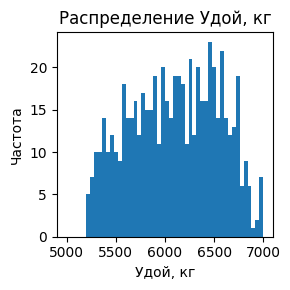

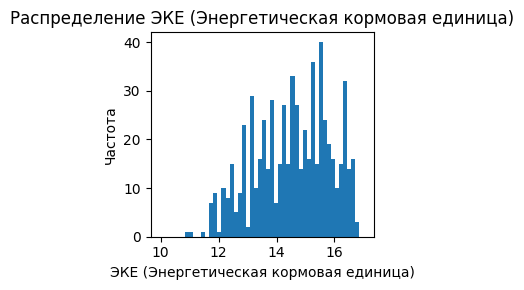

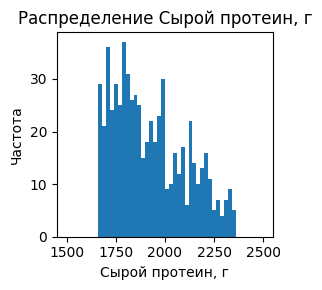

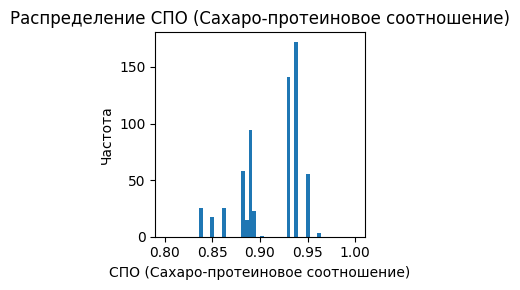

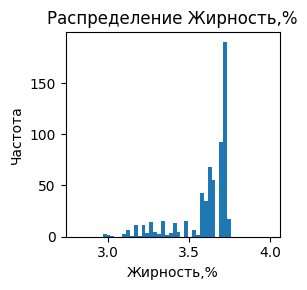

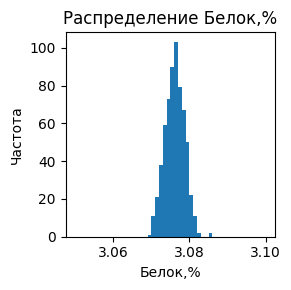

In [112]:
# Построение диаграмм для признаков
# Строим графики для каждой числовой переменной
numeric_columns = [
    'Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г',
                   'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%'
]
ranges = [(5000, 7000), (10, 17), (1500, 2500), (0.8, 1.0), (2.8, 4), (3.05, 3.1)]
for ind, col in enumerate(numeric_columns):
    plt.figure(figsize=(3, 3))  # Создаем новую фигуру для каждого графика
    plt.hist(df1[col], bins=50, range=ranges[ind])  # Гистограмма для числовых данных
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

Гистограммы похожи на "гребёнку". Скорее всего разные данные распределяются по разным критериям - папам, лугам, возрасту и т.д.

Графики для категориальных столбцов

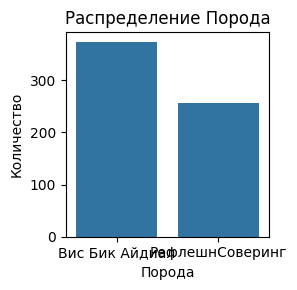

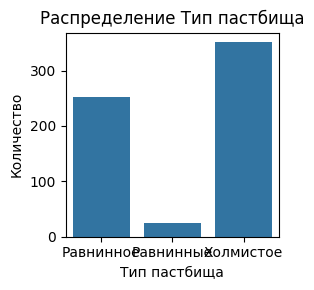

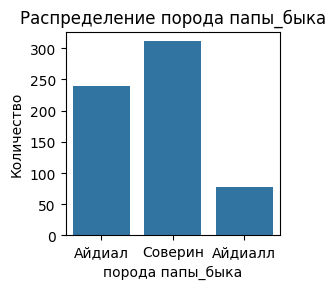

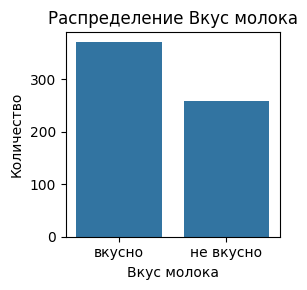

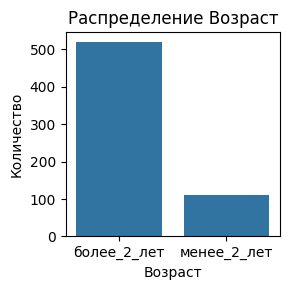

In [116]:
# Категориальные признаки
categorical_columns = df1.select_dtypes(include=['object']).columns

# Строим графики для каждой категориальной переменной
for col in categorical_columns:
    plt.figure(figsize=(3, 3))  # Создаем новую фигуру для каждого графика
    sns.countplot(x=col, data=df1)  # Бар-диаграмма для категориальных данных
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()